## Graph-Based Summarization 圖論摘要方法
Graph-Based Summarization的主要概念是把文章轉換成圖論，然後利用演算法(PageRank)找出最重要和句子來做摘要。在一個文章圖論中，每個節點會代表一個句子，而線段會代表節點/句子之間的相似度(cosine similarity)。一些知名的演算法包括TextRank和LexRank——兩個都利用PageRank的演算法來計算最重要的句子。這個示範會利用到PageRank和cosine similarity，但是不同的演算法和相似度會輸出不同的效果。

PageRank是一Google發展出來的演算法，用來做Google搜尋引擎結果中的網頁進行排名。它的排名方法主要是看一個網頁鏈接的數量和質量來計算一個網站有多重要。PageRank的假設是更重要的網站更有可能會從其它網站獲得更多鏈接(線段)。圖論摘要方法也是依照這個道理計算文章裏重要和適合做摘要的句子。它會找出每個句子之間的相似度，然後依照PageRank的演算法和道理，最重要的句子會最像文章裏的其他句子(最多線段和相似度最高的句子/節點)。除了做單文件摘要，圖論摘要方法也適合做關鍵字萃取和多文件摘要。


圖論摘要方法可以分成幾個主要步驟:
1. 將文本分句
2. 把文本轉換成vector，並利用vector創造一個sparse matrix
3. 計算每個vector的cosine similarity，再創造一個similarity matrix
4. 構建圖論模型，節點為句子，線段為句子之間的cosine similarity
5. 用PageRank演算法取得句子的分數，然後排序並取最高得分的句子作爲摘要

## 讀取資料
- 讀取爬文和下載好的100篇文章

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
import pandas as pd
import numpy as np
import networkx as nx
import jieba
import re
import collections
from collections import Counter

In [2]:
import pandas as pd
news100 = pd.read_excel('appledaily_politinews100.xlsx')
news100.head()

,category,content,title
0,政治,總統蔡英文卸任民進黨主席，昨在臉書po給黨員的一封信，信中說，民進黨會展開一場轟轟烈烈的檢討...,蔡英文要轟轟烈烈檢討民進黨 林濁水酸：民主國家沒聽過
1,政治,民進黨這次九合一選舉慘敗，蔡英文辭去黨主席一職，昨公布「給黨員的一封信」，內容提到，最該改變...,他列民進黨10大豬隊友 「不下架將賠上2020」
2,政治,2018年地方選舉國民黨拿下空前勝利，執政地區從6縣市竄升為15縣市，昨中常會上國民黨提出選...,選戰檢討報告出爐 國民黨：落選者「缺乏對外拓票企圖心」
3,政治,準高雄市長韓國瑜的愛女韓冰昨(28日)受邀上政論節目《54新觀點》，首度與民進黨台北市議員王...,不用跳愛河！韓冰邀替高雄拚觀光 王世堅靦腆：可以廢物利用
4,政治,點我直接觀看 被操弄的民調？《蘋果》數據解密,【民調解密3】林佳龍敗在紫爆 盧秀燕跌破眼鏡大勝


## 清理文集並創建語料庫
- 清理爬下來文集（刪除標點符號，數字，和停止詞）
- 設定/創造詞庫
- 創造語料庫，然後把它轉換成電腦能分析的格式

In [3]:
text = news100['content']

# 設定適合的標點符號和停止詞
import requests
punctuation = [' ','；','，','。','！','：','「','」','｣','…','、','？','【','】','.',':','?',';','!','~','`','+','-','<','>','/','[',']','{','}',"'",'"',     '\xa0','%','）','（','\u3000','\u200b','\t','／']
stop = requests.get('https://raw.githubusercontent.com/tomlinNTUB/Machine-Learning/master/data/%E5%81%9C%E7%94%A8%E8%A9%9E-%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87.txt', verify = False)
stopwords = stop.text.split('\r\n')
addedStops = ['httpswwwfacebookcomappledailytw','nannan','好','已','最']

# 刪除標點符號和數字
cleanText = []
for doc in text:
    onedoc=''
    for char in str(doc).replace('\n',''):
        if char not in punctuation and not char.isdigit() :#and char not in stopwords
            onedoc += char
    cleanText.append(onedoc)

# 設定詞庫和加詞
import jieba
jieba.set_dictionary('dict.txt.big.txt') # 應用繁體詞庫
jieba.add_word('蔡英文') # 加新詞進入詞庫
jieba.add_word('韓國瑜')
jieba.add_word('柯P')
jieba.add_word('柯文哲')
jieba.add_word('邱豐光')
jieba.add_word('民進黨')
jieba.add_word('國民黨')

# 創造語料庫，刪除停止詞
corpus = [] # 語料庫
for cleanDoc in cleanText:
    textList = jieba.lcut(cleanDoc, cut_all=False)
    noBrakesList = []
    for phrase in textList:
        if phrase not in stopwords and phrase not in addedStops:
            noBrakesList.append(phrase)
    corpus.append(' '.join(noBrakesList))

#corpus

D:\Anaconda3\lib\site-packages\urllib3\connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
Building prefix dict from C:\Users\YB0002777\Desktop\Learning Python\dict.txt.big.txt ...
Loading model from cache C:\Users\YB0002~1\AppData\Local\Temp\jieba.u018f3a7b0c6b32cba5278025feb505ed.cache
Loading model cost 1.256 seconds.
Prefix dict has been built succesfully.


In [4]:
# 把語料庫和文章轉換成 vector
vect = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', max_features = 6500)
corpus_tfidf = vect.fit_transform(corpus)

In [5]:
# 語料庫 vector shape
print('Corpus Shape:\t', corpus_tfidf.shape)

Corpus Shape:	 (100, 6500)


In [6]:
# 語料庫最高TF-IDF分數的100個單詞/最重要的單詞
import numpy as np
feature_array = np.array(vect.get_feature_names())
tfidf_sorting = np.argsort(corpus_tfidf.toarray()).flatten()[::-1]

n = 100
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['邱豐光', '邱', '開口', '侯', '副', '市長', '目前', '柯文哲', '多以', '邱任', '邱力',
       '人脈廣', '必達', '明升暗降', '搶人', '空穴來風', '商界', '看待', '冀望', '看上', '弟',
       '探詢', '使命', '將於月', '強邱', '調往', '警政', '正式', '王嘉慶', '警', '去年', '警察局',
       '不約而同', '大學', '大戰', '柯侯', '宜', '周刊', '警政署', '人侯友', '副手', '喜歡',
       '各縣市', '私下', '回覆', '來當', '早', '署長', '發現', '一場', '就職', '幕僚', '王',
       '侯友宜', '做好', '柯p', '局長', '綜合', '意願', '議會', '外界', '交換', '前度', '片',
       '邁選', '報導', '效果', '曝光', '挺', '展開', '首長', '協議', '密約', '重要', '找',
       '新北', '君子', '結束', '溝通', '當時', '落幕', '對此', '工作', '選戰', '討論', '決定',
       '台北市', '原本', '參選', '前', '日', '時', '韓國瑜', '月', '當選', '陳', '選舉',
       '知道', '想', '表示'], dtype='<U33')

## Vectorize文章並找出最適合做摘要的句子
- 把文章分成句子
- 把句子轉換成vector，然後計算每個句子的TF-IDF分數

In [7]:
# 選擇文章，把文章分成句子
docNum = 31
testDoc = news100['content'][docNum]
testTitle = news100['title'][docNum]

import re
def splitSentences(document):
    #for sent in re.findall(u'[^!?。\.\!\?]+[!?。\.\!\?]?', paragraph, flags=re.U):
    for sent in re.findall(u'[^!?。\!\?]+[!?。\!\?]?', document, flags=re.U):
        yield sent

sentenceDoc = []
for sent in list(splitSentences(testDoc))[:-1]:
    sentenceDoc.append(' '.join(jieba.cut(sent)))

# 原本文章
testDoc

'今年九合一大選投票狀況多，據了解，中選會官方網站在投票日當天曾遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊，所幸在負責網路維護中華電信應變下，未進一步造成影響。中選會副主委陳朝建今證實曾遭駭客攻擊，不過計票網路是封閉系統，並非公開網路，無法由外界接取，因此沒有任何影響，境外網路干擾也並未影響投票進程。行政院發言人Kolas Yotaka（谷辣斯・尤達卡）表示，中選會在選前即做好縝密防護，因此成功防堵攻擊，接下來將針對有形的選務如投票排隊問題，以及無形的選務如資安防護進行檢討。不過，投票日當天開票進程緩慢，台北市選情更創下史上第一次開票長達9小時的紀錄，陳朝建說明，開票時間長是因為投票時間延後，計票不受駭客影響，開票也自然不受此影響。據內部消息指出，投票日當天曾出現從境外進行分散式阻斷服務（DDoS）攻擊，企圖癱瘓中選會網站，不過在中華電信、中選會緊急處理後，阻斷來自國外異常流量，在短時間獲得解決，一般民眾並沒有發現特殊異樣。NCC及中華電信暫未對此做進一步說明。陳朝建表示，受攻擊的是中選會官方網站，當日開票的計票網路是獨立的封閉網路，並非公開網路，無法由外界接取，完全未有任何影響；中華電信團隊也是24小時監控與防護作業，也沒有受到任何影響。陳朝建說，受到攻擊的官網，當日皆有隨時防衛，中華電信團隊24小時監控與防護作業；故當日遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊時，在負責網路維護中華電信的緊急應變下，並沒有受到影響。另外，Kolas表示，中選會的官網在選舉當天上午6時56分至7時01分期間，遭受大規模境外DDoS攻擊，而中選會的系統是封閉系統，防護非常嚴密，因此沒被攻擊，而當因中選會在選前即做好縝密的防護，當天其實沒因網路攻擊發生意外狀況，中選會的資安管理有成功防堵攻擊。Kolas表示，所幸這次在事前有預見可能的危險，中選會的資料庫、網站等都沒遭受損害，而在資訊時代，行政院希望在這波中選會的選務檢討中，不只針對有形被詬病的排隊投票問題，無形的選務如資安防護，也會進行檢討、加強。（林惟崧、鄭鴻達／台北報導）出版：1454更新：1942（新增行政院說法） \xa0想知道更多，一定要看……【獨家】投票日遭境外駭客攻擊\u3000中選會網站險癱瘓看了這則新聞的人，也看了……老里長險勝1票\u3000美女里長候選人要求驗票發祭品囉！\u3000韓總雞排逾千

In [8]:
# 分詞後的文章
sentenceDoc

['今年 九 合一 大選 投票 狀況 多 ， 據 了解 ， 中選會 官方網站 在 投票 日 當天 曾 遭到 來自 境外 大規模 分散式 阻斷 服務 （ DD0oS ） 攻擊 ， 所幸 在 負責 網路 維護 中華電信 應變 下 ， 未 進一步 造成 影響 。',
 '中選會 副 主委 陳 朝 建今 證實 曾 遭 駭客 攻擊 ， 不過 計票 網路 是 封閉系統 ， 並非 公開 網路 ， 無法 由 外界 接取 ， 因此 沒有 任何 影響 ， 境外 網路 干擾 也 並未 影響 投票 進程 。',
 '行政院 發言人 Kolas   Yotaka （ 谷辣斯 ・ 尤 達卡 ） 表示 ， 中選會 在 選前 即 做好 縝密 防護 ， 因此 成功 防堵 攻擊 ， 接下來 將 針對 有形 的 選務 如 投票 排隊 問題 ， 以及 無形 的 選務 如資安 防護 進行 檢討 。',
 '不過 ， 投票 日 當天 開票 進程 緩慢 ， 台北市 選情 更 創下 史上 第一次 開票 長達 9 小時 的 紀錄 ， 陳 朝建 說明 ， 開票 時間 長 是 因為 投票 時間 延後 ， 計票 不 受 駭客 影響 ， 開票 也 自然 不受 此 影響 。',
 '據 內部消息 指出 ， 投票 日 當天 曾 出現 從 境外 進行 分散式 阻斷 服務 （ DDoS ） 攻擊 ， 企圖 癱瘓 中選會 網站 ， 不過 在 中華電信 、 中選會 緊急 處理 後 ， 阻斷 來自 國外 異常 流量 ， 在 短時間 獲得 解決 ， 一般 民眾並 沒有 發現 特殊 異樣 。',
 'NCC 及 中華電信 暫未 對此 做 進一步 說明 。',
 '陳 朝建 表示 ， 受 攻擊 的 是 中選會 官方網站 ， 當日 開票 的 計票 網路 是 獨立 的 封閉 網路 ， 並非 公開 網路 ， 無法 由 外界 接取 ， 完全 未有 任何 影響 ； 中華電信 團隊 也 是 24 小時 監控 與 防護 作業 ， 也 沒有 受到 任何 影響 。',
 '陳 朝建 說 ， 受到 攻擊 的 官網 ， 當日 皆 有 隨時 防衛 ， 中華電信 團隊 24 小時 監控 與 防護 作業 ； 故 當日 遭到 來自 境外 大規模 分散式 阻斷 服務 （ DD0oS ） 攻擊 時 ， 在 負責 網路 維護 中華電信 的 緊急 應變 下 ， 並 沒有 受到 影

In [9]:
# 把文章轉換成 vector，並創造一個 sparse matrix
doctor_tfidf = vect.transform(sentenceDoc)
doctor_tfidf

<10x6500 sparse matrix of type '<class 'numpy.float64'>'
	with 263 stored elements in Compressed Sparse Row format>

## 計算句子相似度
- 把文章轉換成 vector 以後可以用來計算句子之間的相似度依照TF-IDF分數(cosine similarity)
- 用 cosine similarity 創造 similarity matrix

In [10]:
# 創造空的 similarity matrix (相似度矩陣)
sim_matrix = np.zeros([len(sentenceDoc), len(sentenceDoc)])
sim_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
# 用 cosine similarity 計算文章句子之間的相似度，並把空的 similarity matrix 填滿
for i in range(len(sentenceDoc)):
    for j in range(len(sentenceDoc)):
        if i != j:
            sim_matrix[i][j] = cosine_similarity(doctor_tfidf[i], doctor_tfidf[j])[0,0]
            #sim_matrix[i][j] = cosine_similarity(doctor_tfidf[i].reshape(1,100), doctor_tfidf[j].reshape(1,100))[0,0]

sim_matrix

array([[0.        , 0.28932826, 0.07071838, 0.12412599, 0.40618577,
        0.16729712, 0.28698711, 0.5139728 , 0.28538874, 0.09787338],
       [0.28932826, 0.        , 0.05486499, 0.21259262, 0.10609694,
        0.        , 0.55933654, 0.20667443, 0.26784045, 0.04087918],
       [0.07071838, 0.05486499, 0.        , 0.02112692, 0.07366853,
        0.        , 0.1397056 , 0.12862096, 0.42785049, 0.53365807],
       [0.12412599, 0.21259262, 0.02112692, 0.        , 0.04841702,
        0.03906373, 0.24261615, 0.0947003 , 0.03329598, 0.01936448],
       [0.40618577, 0.10609694, 0.07366853, 0.04841702, 0.        ,
        0.08106393, 0.08295373, 0.31567354, 0.23925864, 0.10862471],
       [0.16729712, 0.        , 0.        , 0.03906373, 0.08106393,
        0.        , 0.08336997, 0.14799011, 0.        , 0.        ],
       [0.28698711, 0.55933654, 0.1397056 , 0.24261615, 0.08295373,
        0.08336997, 0.        , 0.4983989 , 0.25687401, 0.07563192],
       [0.5139728 , 0.20667443, 0.1286209

## 構建圖論並應用PageRank演算法
- 把創造好的similarity matrix畫成圖論，再用PageRank找出最重要的句子

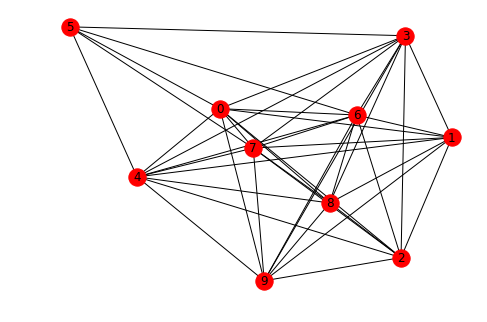

In [20]:
# 把 similarity matrix 變成成圖論（節點代表句子，線段代表相似度）
import networkx as nx
nx_graph = nx.from_numpy_array(sim_matrix)
nx.draw(nx_graph, with_labels=True)

In [13]:
# 轉換成圖論後再用 PageRank 演算法找出最重要的句子
scores = nx.pagerank(nx_graph)
scores

{0: 0.13643716537803235,
 1: 0.1069935473146541,
 2: 0.09277224040681233,
 3: 0.059179207114872165,
 4: 0.09305402631165097,
 5: 0.04228665394768518,
 6: 0.13470992339887847,
 7: 0.13568615148632335,
 8: 0.12321699784293326,
 9: 0.0756640867981581}

In [14]:
# 最重要的三個句子
from collections import Counter
c = Counter(scores)
c.most_common(3)

[(0, 0.13643716537803235), (7, 0.13568615148632335), (6, 0.13470992339887847)]

## 長文摘要
- 從PageRank的結果中找出最適合做摘要的句子

In [15]:
# 選擇摘要的長度
sentCount = 3

# 找出 PageRank 算最重要的句子做摘要
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentenceDoc)), reverse=True)

summarySentences = []
for i in range(sentCount):
    summarySentences.append(ranked_sentences[i][1])

sentenceDic = {}
for sentence in summarySentences:
    sentenceDic[sentenceDoc.index(sentence)] = sentence.replace(' ','').strip()
    
import collections
orderedDic = collections.OrderedDict(sorted(sentenceDic.items()))

print('標題: ' + '《' + testTitle + '》')
for k, v in orderedDic.items():
    print('Sentence ' + str(k) + '\n', v)

標題: 《中選會證實投票日遭駭客攻擊　行政院：成功防堵》
Sentence 0
 今年九合一大選投票狀況多，據了解，中選會官方網站在投票日當天曾遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊，所幸在負責網路維護中華電信應變下，未進一步造成影響。
Sentence 6
 陳朝建表示，受攻擊的是中選會官方網站，當日開票的計票網路是獨立的封閉網路，並非公開網路，無法由外界接取，完全未有任何影響；中華電信團隊也是24小時監控與防護作業，也沒有受到任何影響。
Sentence 7
 陳朝建說，受到攻擊的官網，當日皆有隨時防衛，中華電信團隊24小時監控與防護作業；故當日遭到來自境外大規模分散式阻斷服務（DD0oS）攻擊時，在負責網路維護中華電信的緊急應變下，並沒有受到影響。


**會提高摘要效果的改進** 
1. 更好的分詞/分句子，詞庫，和語料庫會有更好的效果/摘要
2. 利用同義詞加強詞庫
3. 不管是單詞還是句子，相似度计算太表面的話，没有涉及到語義層面，效果不会太好(原因是sentence vector的质量不高，但是word vector的质量算滿高)
    - 句子得分模型只會依靠句子相似度，沒有考慮到句子之間的語義關係——如果有的話，得到的效果感觉会比較好
4. 更進階的方法計算句子的重要性
    - word embeddings (e.g. word2vec)

In [16]:
# graph-based 摘要，輸入文章的號碼和摘要長度
def graphSummarizer(docNumber, sumLength):
    testDoc = news100['content'][docNumber]
    testTitle = news100['title'][docNumber]

    sentenceDoc = []
    for sent in list(splitSentences(testDoc))[:-1]:
        sentenceDoc.append(' '.join(jieba.cut(sent)))
        
    doc_tfidf = vect.transform(sentenceDoc)
    
    sim_matrix = np.zeros([len(sentenceDoc), len(sentenceDoc)])
    for i in range(len(sentenceDoc)):
        for j in range(len(sentenceDoc)):
            if i != j:
                sim_matrix[i][j] = cosine_similarity(doc_tfidf[i], doc_tfidf[j])[0,0]
                
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentenceDoc)), reverse=True)

    summarySentences = []
    for i in range(sumLength):
        summarySentences.append(ranked_sentences[i][1])

    sentenceDic = {}
    for sentence in summarySentences:
        sentenceDic[sentenceDoc.index(sentence)] = sentence.replace(' ','').strip()
    
    import collections
    orderedDic = collections.OrderedDict(sorted(sentenceDic.items()))

    print('標題: ' + '《' + testTitle + '》')
    print(testDoc, '\n')
    
    #nx.draw(nx_graph, with_labels=True)
    
    print('標題: ' + '《' + testTitle + '》')
    for k, v in orderedDic.items():
        print('Sentence ' + str(k) + '\n', v)

In [17]:
# 稍微短一點的文章，第99篇
graphSummarizer(99,3)

標題: 《柯、侯都愛！副市長虛位以待　邱豐光人氣破表》
選戰落幕，各縣市首長將於12月25日就職，一場搶人大戰正式展開！台北市警察局前局長邱豐光，去年9月被調往警政署任副署長，外界多以「明升暗降」看待。如今選舉結束，台北市長柯文哲、新北市長當選人侯友宜不約而同看上邱，冀望找他來當副市長。《周刊王》報導，柯文哲原本不喜歡邱豐光，後來發現邱「很好用」，不僅對議會的溝通效果比副市長強，邱在商界人脈廣，只要柯P開口，邱使命必達。侯友宜雖是邱豐光警大學弟，但據報導，早在侯決定參選時，已私下探詢邱任副手的意願，當時邱力挺，「只要侯開口，絕對會去。」對此傳聞，柯、侯幕僚均表示目前沒討論。邱豐光回覆「空穴來風」，目前最重要的是做好警政工作。（王嘉慶／綜合報導）想知道更多，一定要看……【君子片】密約曝光！韓國瑜、陳其邁　選前3度交換協議 

標題: 《柯、侯都愛！副市長虛位以待　邱豐光人氣破表》
Sentence 2
 《周刊王》報導，柯文哲原本不喜歡邱豐光，後來發現邱「很好用」，不僅對議會的溝通效果比副市長強，邱在商界人脈廣，只要柯P開口，邱使命必達。
Sentence 3
 侯友宜雖是邱豐光警大學弟，但據報導，早在侯決定參選時，已私下探詢邱任副手的意願，當時邱力挺，「只要侯開口，絕對會去。
Sentence 4
 」對此傳聞，柯、侯幕僚均表示目前沒討論。


In [18]:
# 稍微長一點的文章，第40篇
graphSummarizer(40,3)

標題: 《坦言「​總統大選光環已過」　蔡英文座談會聚焦基層》
總統蔡英文下午前往宜蘭展開「傾聽之旅」第二站，歷經2小時的座談會，下午5時許蔡英文等人離開會場。被問到是否會參選2020、非核家園2025等問題蔡英文笑而不答，而被問到農委會主委林聰賢是否應該下台一事，她一度欲言又止，最後還是上車離去。 與會的宜蘭縣小英之友會理事曹光炎說，總統放下身段傾聽基層聲音，他相信基層聲音總統都聽到了，民進黨也會虛心改進，尤其是照顧弱勢的農漁工，還說「民進黨的失敗，不是因為國民黨的強，而是因為沒有傾聽人民的聲音」。會中並沒有針對特定人士是否下台進行討論。 民進黨宜蘭縣黨部主委黃進財也說，會中探討執政上遇到、需要改進的問題，並沒有提到行政官員是否下台的部分。他說，各領域都有探討，包括一例一休、農漁會與空污法問題，都有討論到，而執政上沒有立即接地氣與民意站在一起都有做深切檢討。 黃進財也表示，座談會中也多所提及農業政策，包括農地、農舍等議題及農漁民收入、農業產銷穩定等問題都有熱烈討論，總統也相當重視。 另外，宜蘭市長江聰淵表示，在於內閣部分有特別提到，人才尋覓是相當重要課題，過去都被批評是用老宅男、老藍男等問題，人才尋找是當務之急，對於人才培養、部會的養成，因此才會繼續慰留陳菊及賴清德繼續承擔責任。 對於局部調整，也聽很多基層鄉親意見，包括勞工、漁民、政策等問題，中央部會未在第一時間解決，總統承諾未來會經常下鄉聽取民眾聲音，會透過她直接與部會溝通，而非侷限在建議案到她手中後才與部會商量，將來會以下鄉的方式，解決民眾需求，直接了解民眾心聲。 另外，江聰淵也說，許多政策議題上很多有爭議性，總統也處於兩難，包括廢死刑屬國際議題，國際友邦要求不能執行死刑，但國人對於廢死也有反對立場，公投案也處於對立，造成執政者負擔。如今執政運作上問題浮現，須面對問題並解決。 江聰淵說，蔡英文在會中表示「總統大選時的光環已經過去了」，會虛心檢討，鼓勵基層民眾，重拾信心，改革與政策推動，會與地方謀定而後動，最重要的民生議題，包括一例一休等相關政策，會再找出明確性的推動方向。 對於縣黨部輔選不力部分，確實有人提議檢討，江聰淵表示，會中也曾討論到農委會主委，總統說前後兩任均是出身農業大縣的縣長，她給予充分授權，未來要再尋覓有敏感性、能替政府、百姓解決問題的人才，是總統擔憂的部分，但她相信有此時間歷練，各部會都進入狀況

In [19]:
# 效果不太好的摘要，第1篇
graphSummarizer(1,3)

標題: 《他列民進黨10大豬隊友　「不下架將賠上2020」》
民進黨這次九合一選舉慘敗，蔡英文辭去黨主席一職，昨公布「給黨員的一封信」，內容提到，最該改變的人就是她自己，「責任由我一肩扛起，同志之間不必互相為難。」前立委孫大千則說，「蔡總統又不能辭職下台，那要如何一肩扛起所有責任？這不又是一句空話嗎？」孫大千今天上午在臉書發文，倘若民進黨真的希望能夠救亡圖存，力挽狂瀾，建議在最短的時間內，不論是用勸退、勸辭、或是撤換的方式，讓下列十大「豬隊友」下架，「如果捨不得這十個人，保證會賠上民進黨2020年的政權。」第一，副總統陳建仁理由：823水災時，當南部鄉親還泡在水裡，但是這個人卻在金門玩好玩滿了3天。第二，總統府秘書長陳菊理由：把高雄市整到「又老又窮」，和滿朝盡是「菊家班」。第三，行政院長賴清德理由：「幹話王」的形象早已深植人心。第四，行政院發言人谷辣斯理由：不但有酒駕前科，更不忘記把政府提供給弱勢原住民的法扶資源「用好用完」。第五，駐日代表謝長廷理由：有空回台輔選黨內同志，卻無心援助台灣旅客。第六，交通部長吳宏謀理由：高雄市五千個「天坑」的推手，以及普悠瑪事件的政治責任。第七，農委會副主委李退之理由：豐年社社長汪文豪的「被請辭事件」。第八，監察委員陳師孟理由：替民進黨把司法檢調系統，幾乎一次羞辱、踐踏、得罪完畢。第九，北農總經理吳音寧理由：看到這位有蔡英文當靠山的「高級實習生」，只會讓年輕人一肚子怨氣。第十，中華電信董事長鄭優理由：從「499之亂」，到後續的內部爭議連環爆，他必然將會成為在野黨的下一個靶子。（即時新聞中心／綜合報導）看了這則新聞的人，也看了……14年前撞死人判緩刑 　韓國瑜下午將出面說明不用跳愛河！韓冰邀替高雄拚觀光　王世堅靦腆：可以廢物利用蔡英文要站第一線　林濁水諷：賴清德變隨身特助 

標題: 《他列民進黨10大豬隊友　「不下架將賠上2020」》
Sentence 3
 第二，總統府秘書長陳菊理由：把高雄市整到「又老又窮」，和滿朝盡是「菊家班」。
Sentence 6
 第五，駐日代表謝長廷理由：有空回台輔選黨內同志，卻無心援助台灣旅客。
Sentence 7
 第六，交通部長吳宏謀理由：高雄市五千個「天坑」的推手，以及普悠瑪事件的政治責任。
